In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import os
from tqdm import tqdm

In [2]:
# define dataset inputs

# csvPath = '/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5206/project/data/jena_climate_2009_2016.csv'
csvPath = '/Users/haidiazaman/Desktop/dsa5206-project/data/jena_climate_2009_2016.csv'

batch_size = 512
train_size,val_size,test_size = 0.7,0.2,0.1
lookback = 10
date_col_name = 'Date Time'
value_col_names = [
    'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
    'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
    'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
    'wd (deg)'
]

target_variable = 'T (degC)'

In [3]:
# define model inputs


input_size = 14
hidden_size=1
num_stacked_layers=1
lr=0.001
epochs = 10

scheduler_factor=0.5
scheduler_patience=3

early_stopping_limit = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
- preprocess dataset
    - format into df with lookback window
    - normalize features
    - train val test split

In [4]:
# define dataloader class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


# format df into df with lookback window
def prepare_shifted_df(df, n_steps, date_col_name, value_col_name):
    df = dc(df)
    df.set_index(date_col_name, inplace=True)
    for i in range(1, n_steps+1):
        df[f'{value_col_name}(t-{i})'] = df[value_col_name].shift(i)
    df.dropna(inplace=True)
    return df


def process_shifted_df(shifted_df,lookback):
    # format X and y from df and scale it
    shifted_df_as_np = shifted_df.to_numpy()
    # print(shifted_df_as_np.shape)

    # normalise the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    # print(X.shape, y.shape)
    X = dc(np.flip(X, axis=1))

    X = X.reshape(-1,lookback,1)
    y = y.reshape(-1,1)
    return X,y

In [7]:
full_data = pd.read_csv(csvPath)
full_data[date_col_name] = pd.to_datetime(full_data[date_col_name])

value_col_name =  value_col_names[0]
data = full_data[[date_col_name,value_col_name]]
shifted_df = prepare_shifted_df(data, lookback, date_col_name, value_col_name)
X,y = process_shifted_df(shifted_df,lookback)

for value_col_name in tqdm(value_col_names[1:]):
    data = full_data[[date_col_name,value_col_name]]
    shifted_df = prepare_shifted_df(data, lookback, date_col_name, value_col_name)
    X_,y_ = process_shifted_df(shifted_df,lookback)

    X = np.concatenate((X,X_),axis=2)
    y = np.concatenate((y,y_),axis=1)



# shortlist only the target_variable for y
y = y[:,value_col_names.index(target_variable)].reshape(-1,1)

X.shape,y.shape

100%|██████████| 13/13 [00:02<00:00,  4.64it/s]


((420541, 10, 14), (420541, 1))

In [8]:
# train test split
X_train = X[:int(len(X) * train_size)]
X_val = X[int(len(X) * train_size):int(len(X) * train_size)+int(len(X) * val_size)]
X_test = X[int(len(X) * train_size)+int(len(X) * val_size):]
print(X_train.shape, X_val.shape, X_test.shape)
y_train = y[:int(len(y) * train_size)]
y_val = y[int(len(y) * train_size):int(len(y) * train_size)+int(len(y) * val_size)]
y_test = y[int(len(y) * train_size)+int(len(y) * val_size):]
print(y_train.shape, y_val.shape, y_test.shape)

# convert to torch tensor
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
print(X_train.shape, X_val.shape, X_test.shape)
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
y_test = torch.tensor(y_test).float()
print(y_train.shape, y_val.shape, y_test.shape)

(294378, 10, 14) (84108, 10, 14) (42055, 10, 14)
(294378, 1) (84108, 1) (42055, 1)
torch.Size([294378, 10, 14]) torch.Size([84108, 10, 14]) torch.Size([42055, 10, 14])
torch.Size([294378, 1]) torch.Size([84108, 1]) torch.Size([42055, 1])


In [9]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # set all shuffle=False since its sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [10]:
# print to check
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([512, 10, 14]) torch.Size([512, 1])


# Dimensionality reduction - Nonlinear Autoencoder 1 - simple FCN autoencoder

In [ ]:
# define autoencoder model

class Autoencoder(nn.Module):
    def __init__(self, input_features, lookback, hidden_size):
        super(Autoencoder, self).__init__()
        self.input_features = input_features
        self.lookback = lookback
        self.encoder = nn.Sequential(
            nn.Linear(input_features*lookback, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, input_features*lookback),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input tensor
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), self.lookback, self.input_features)  # Reshape back to original shape (batch, lookback, 2)
        return decoded

# Example usage:
input_features = 14
lookback = 10
hidden_size = 20
model = Autoencoder(input_features=input_features, lookback=lookback, hidden_size=hidden_size).to(device)

# Forward pass
output = model(x_batch.to(device))
print(x_batch.shape)
print("Output shape:", output.shape)

torch.Size([512, 10, 14])
Output shape: torch.Size([512, 10, 14])


## Train autoencoder

In [ ]:
# Train the model - calc reconstruction loss only

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
autoencoder_model = Autoencoder(
    input_features=input_features,
    lookback=lookback,
    hidden_size=hidden_size
).to(device)
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    autoencoder_model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, _ = batch
        x_batch = x_batch.to(device)

        optimizer.zero_grad()
        outputs = autoencoder_model(x_batch)
        loss = criterion(outputs, x_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    autoencoder_model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, _ = batch
            x_batch = x_batch.to(device)
            outputs = autoencoder_model(x_batch)
            loss = criterion(outputs, x_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(autoencoder_model.state_dict(), 'autoencoder_model.pt')
        print(f'autoencoder_model epoch {epoch} saved as autoencoder_model.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

epoch 0
autoencoder_model epoch 0 saved as autoencoder_model.pt
Epoch 1/100, train loss: 0.2043, val loss: 0.1789, time_taken: 3.5
epoch 1
autoencoder_model epoch 1 saved as autoencoder_model.pt
Epoch 2/100, train loss: 0.1854, val loss: 0.1767, time_taken: 3.2
epoch 2
autoencoder_model epoch 2 saved as autoencoder_model.pt
Epoch 3/100, train loss: 0.1847, val loss: 0.1765, time_taken: 4.5
epoch 3
autoencoder_model epoch 3 saved as autoencoder_model.pt
Epoch 4/100, train loss: 0.1847, val loss: 0.1765, time_taken: 3.4
epoch 4
autoencoder_model epoch 4 saved as autoencoder_model.pt
Epoch 5/100, train loss: 0.1846, val loss: 0.1765, time_taken: 3.2
epoch 5
autoencoder_model epoch 5 saved as autoencoder_model.pt
Epoch 6/100, train loss: 0.1844, val loss: 0.1761, time_taken: 3.8
epoch 6
autoencoder_model epoch 6 saved as autoencoder_model.pt
Epoch 7/100, train loss: 0.1839, val loss: 0.1755, time_taken: 3.9
epoch 7
autoencoder_model epoch 7 saved as autoencoder_model.pt
Epoch 8/100, train 

In [ ]:
nn.MSELoss()(model(x_batch),x_batch)

tensor(0.4275, device='cuda:0', grad_fn=<MseLossBackward0>)

# Dimensionality reduction - Nonlinear Autoencoder 2 - LSTM autoencoder

In [13]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm_encoder = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc_encoder = nn.Linear(hidden_size, 2)

        self.fc_decoder = nn.Linear(2, hidden_size)
        self.lstm_decoder = nn.LSTM(hidden_size, input_size, num_stacked_layers,batch_first=True)

    def forward(self, x):
        batch_size = x.size(0) # input must be torch tensor

        # ENCODE
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # short term memory
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # long term memory
        out, _ = self.lstm_encoder(x, (h0, c0)) # output is output, (h_n, c_n), but we dont need to track the next state h1,c1 as the model does it for us
        # out shape is (batch_size, num_timesteps inclusive of predicted day, num_features_in_hidden_state)
        out = self.fc_encoder(out)

        # DECODE
        out = self.fc_decoder(out)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.input_size).to(device) # short term memory
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.input_size).to(device) # long term memory
        out, _ = self.lstm_decoder(out, (h0, c0)) # output is output, (h_n, c_n), but we dont need to track the next state h1,c1 as the model does it for us

        return out

input_size = 14 # features
hidden_size = 4
num_stacked_layers = 1
model = LSTM_Autoencoder(input_size, hidden_size, num_stacked_layers).to(device)
out = model(x_batch.to(device))
out.shape

torch.Size([512, 10, 14])

## Train autoencoder

In [ ]:
# Train the model - calc reconstruction loss only

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()

lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = input_size, #features
    hidden_size = 4,
    num_stacked_layers = num_stacked_layers
).to(device)

optimizer = torch.optim.Adam(lstm_autoencoder_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    lstm_autoencoder_model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, _ = batch
        x_batch = x_batch.to(device)

        optimizer.zero_grad()
        outputs = lstm_autoencoder_model(x_batch)
        loss = criterion(outputs, x_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    lstm_autoencoder_model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, _ = batch
            x_batch = x_batch.to(device)
            outputs = lstm_autoencoder_model(x_batch)
            loss = criterion(outputs, x_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(lstm_autoencoder_model.state_dict(), 'lstm_autoencoder_model.pt')
        print(f'lstm_autoencoder_model epoch {epoch} saved as lstm_autoencoder_model.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

epoch 0
lstm_autoencoder_model epoch 0 saved as lstm_autoencoder_model.pt
Epoch 1/100, train loss: 0.1143, val loss: 0.0460, time_taken: 5.0
epoch 1
lstm_autoencoder_model epoch 1 saved as lstm_autoencoder_model.pt
Epoch 2/100, train loss: 0.0440, val loss: 0.0363, time_taken: 4.1
epoch 2
lstm_autoencoder_model epoch 2 saved as lstm_autoencoder_model.pt
Epoch 3/100, train loss: 0.0379, val loss: 0.0297, time_taken: 3.8
epoch 3
lstm_autoencoder_model epoch 3 saved as lstm_autoencoder_model.pt
Epoch 4/100, train loss: 0.0290, val loss: 0.0234, time_taken: 4.7
epoch 4
lstm_autoencoder_model epoch 4 saved as lstm_autoencoder_model.pt
Epoch 5/100, train loss: 0.0262, val loss: 0.0223, time_taken: 4.1
epoch 5
lstm_autoencoder_model epoch 5 saved as lstm_autoencoder_model.pt
Epoch 6/100, train loss: 0.0252, val loss: 0.0217, time_taken: 4.0
epoch 6
lstm_autoencoder_model epoch 6 saved as lstm_autoencoder_model.pt
Epoch 7/100, train loss: 0.0245, val loss: 0.0212, time_taken: 5.2
epoch 7
lstm_

In [ ]:
# Epoch 81/100, train loss: 0.1742, val loss: 0.1661, time_taken: 3.2
# Epoch 100/100, train loss: 0.0117, val loss: 0.0118, time_taken: 9.2

In [ ]:
nn.MSELoss()(lstm_autoencoder_model(x_batch),x_batch)

tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>)

# Compare autoencoder reconstruction performance

In [ ]:
X_test.shape

torch.Size([42055, 10, 14])

In [ ]:
# # Example usage:
# input_features = 14
# lookback = 10
# hidden_size = 20
# model = Autoencoder(input_features=input_features, lookback=lookback, hidden_size=hidden_size)

# # Forward pass
# output = model(x_batch)
# print(x_batch.shape)
# print("Output shape:", output.shape)

In [ ]:
# load simple autoencoder

autoencoder_model = Autoencoder(
    input_features=input_features,
    lookback=lookback,
    hidden_size=hidden_size
).to(device)
autoencoder_model.load_state_dict(torch.load('autoencoder_model.pt',map_location=device))
autoencoder_model.eval()
print('model loaded')

mse_losses,mae_losses = [],[]
for batch in test_loader:
    x_batch, _ = batch
    x_batch = x_batch.to(device)

    predictions = autoencoder_model(x_batch.to(device))
    mse_loss = nn.MSELoss()(predictions.cpu().detach(),x_batch.cpu().detach())
    mae_loss = nn.L1Loss()(predictions.cpu().detach(),x_batch.cpu().detach())
    mse_losses.append(mse_loss)
    mae_losses.append(mae_loss)

# Compute the average MSE and MAE over all batches
avg_mse_loss = round((sum(mse_losses) / len(mse_losses)).item(),7)
avg_mae_loss = round((sum(mae_losses) / len(mae_losses)).item(),7)

# Print the average MSE and MAE
print("Average MSE Loss:", avg_mse_loss)
print("Average MAE Loss:", avg_mae_loss)

model loaded
Average MSE Loss: 0.1572244
Average MAE Loss: 0.2567081


In [ ]:
# load lstm autoencoder

lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = 14, #features
    hidden_size = 4,
    num_stacked_layers = num_stacked_layers
).to(device)
lstm_autoencoder_model.load_state_dict(torch.load('lstm_autoencoder_model.pt',map_location=device))
lstm_autoencoder_model.eval()
print('model loaded')

mse_losses,mae_losses = [],[]
for batch in test_loader:
    x_batch, _ = batch
    x_batch = x_batch.to(device)

    predictions = lstm_autoencoder_model(x_batch.to(device))
    mse_loss = nn.MSELoss()(predictions.cpu().detach(),x_batch.cpu().detach())
    mae_loss = nn.L1Loss()(predictions.cpu().detach(),x_batch.cpu().detach())
    mse_losses.append(mse_loss)
    mae_losses.append(mae_loss)

# Compute the average MSE and MAE over all batches
avg_mse_loss = round((sum(mse_losses) / len(mse_losses)).item(),7)
avg_mae_loss = round((sum(mae_losses) / len(mae_losses)).item(),7)

# Print the average MSE and MAE
print("Average MSE Loss:", avg_mse_loss)
print("Average MAE Loss:", avg_mae_loss)

model loaded
Average MSE Loss: 0.0059954
Average MAE Loss: 0.0386229


the results show that the LSTM autencoder is far better in mapping the input to a lower dim latent vector than the simple autoencoder as the average MSE and MAE loss on the reconstruction error on test set is much lower (order of magnitude lower)

# Define Models

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0) # input must be torch tensor
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # short term memory
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # long term memory

        out, _ = self.lstm(x, (h0, c0)) # output is output, (h_n, c_n), but we dont need to track the next state h1,c1 as the model does it for us
        # out shape is (batch_size, num_timesteps inclusive of predicted day, num_features_in_hidden_state)
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # rnn only has h0 short term memory, no c0 long term memory

        out, _ = self.rnn(x, h0) # output is (output, h_n) but dont need to manually keep track of the next h1, model does it for us
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        # input size is number of expected features in the input x
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # gru only has h0 memory, no c0 long term memory

        out, _ = self.gru(x, h0) # output is (output, h_n) but dont need to manually keep track of the next h1, model does it for us
        out = self.fc(out[:, -1, :]) # -1 to take the final value of the time series, this is the prediction for the current timestep, changes if dataset format is different, e.g. target at the end instead
        return out

# load LSTM autoencoder for latent vector inference

In [ ]:
lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = 14, #features
    hidden_size = 4,
    num_stacked_layers = num_stacked_layers
).to(device)
lstm_autoencoder_model.load_state_dict(torch.load('lstm_autoencoder_model.pt',map_location=device))
lstm_autoencoder_model.eval()
print('model loaded')

model loaded


In [ ]:
lstm_autoencoder_model

LSTM_Autoencoder(
  (lstm_encoder): LSTM(14, 4, batch_first=True)
  (fc_encoder): Linear(in_features=4, out_features=2, bias=True)
  (fc_decoder): Linear(in_features=2, out_features=4, bias=True)
  (lstm_decoder): LSTM(4, 14, batch_first=True)
)

In [ ]:
# sample inference to get the latent state only

print(f'input shape: {x_batch.shape}')
latent, _ = lstm_autoencoder_model.lstm_encoder(x_batch)
latent = lstm_autoencoder_model.fc_encoder(latent)
latent.shape # reduce 14 to 1 feature

input shape: torch.Size([512, 10, 14])


torch.Size([512, 10, 2])

# RNN - train

In [ ]:
input_size = 2
hidden_size=1
num_stacked_layers=1
lr=0.001
epochs = 10

In [ ]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
model = RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = epochs
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]

for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Encode input data using the autoencoder
        with torch.no_grad():
            latent, _ = lstm_autoencoder_model.lstm_encoder(x_batch)
            latent = lstm_autoencoder_model.fc_encoder(latent)

        optimizer.zero_grad()
        outputs = model(latent)
        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Encode input data using the autoencoder
            latent, _ = lstm_autoencoder_model.lstm_encoder(x_batch)
            latent = lstm_autoencoder_model.fc_encoder(latent)

            outputs = model(latent)
            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'rnn.pt')
        print(f'model epoch {epoch} saved as rnn.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

epoch 0
model epoch 0 saved as rnn.pt
Epoch 1/10, train loss: 0.1185, val loss: 0.0486, time_taken: 4.3
epoch 1
model epoch 1 saved as rnn.pt
Epoch 2/10, train loss: 0.0510, val loss: 0.0222, time_taken: 3.7
epoch 2
model epoch 2 saved as rnn.pt
Epoch 3/10, train loss: 0.0227, val loss: 0.0106, time_taken: 4.6
epoch 3
model epoch 3 saved as rnn.pt
Epoch 4/10, train loss: 0.0136, val loss: 0.0095, time_taken: 3.6
epoch 4
model epoch 4 saved as rnn.pt
Epoch 5/10, train loss: 0.0118, val loss: 0.0091, time_taken: 3.7
epoch 5
model epoch 5 saved as rnn.pt
Epoch 6/10, train loss: 0.0110, val loss: 0.0088, time_taken: 4.3
epoch 6
model epoch 6 saved as rnn.pt
Epoch 7/10, train loss: 0.0104, val loss: 0.0087, time_taken: 4.2
epoch 7
model epoch 7 saved as rnn.pt
Epoch 8/10, train loss: 0.0100, val loss: 0.0086, time_taken: 3.6
epoch 8
model epoch 8 saved as rnn.pt
Epoch 9/10, train loss: 0.0097, val loss: 0.0086, time_taken: 3.9
epoch 9
model epoch 9 saved as rnn.pt
Epoch 10/10, train loss: 0

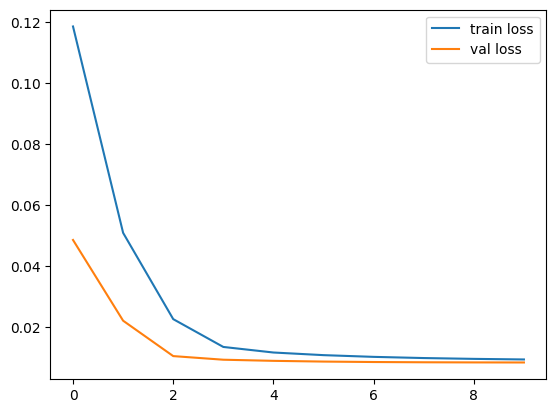

In [ ]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

# LSTM - train

In [ ]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
model = LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = epochs
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]

for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Encode input data using the autoencoder
        with torch.no_grad():
            latent, _ = lstm_autoencoder_model.lstm_encoder(x_batch)
            latent = lstm_autoencoder_model.fc_encoder(latent)

        optimizer.zero_grad()
        outputs = model(latent)
        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Encode input data using the autoencoder
            latent, _ = lstm_autoencoder_model.lstm_encoder(x_batch)
            latent = lstm_autoencoder_model.fc_encoder(latent)

            outputs = model(latent)
            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'lstm.pt')
        print(f'model epoch {epoch} saved as lstm.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

epoch 0
model epoch 0 saved as lstm.pt
Epoch 1/10, train loss: 0.0534, val loss: 0.0301, time_taken: 8.8
epoch 1
model epoch 1 saved as lstm.pt
Epoch 2/10, train loss: 0.0273, val loss: 0.0119, time_taken: 3.7
epoch 2
model epoch 2 saved as lstm.pt
Epoch 3/10, train loss: 0.0112, val loss: 0.0085, time_taken: 4.8
epoch 3
model epoch 3 saved as lstm.pt
Epoch 4/10, train loss: 0.0094, val loss: 0.0085, time_taken: 3.5
epoch 4
Epoch 5/10, train loss: 0.0092, val loss: 0.0086, time_taken: 3.8
epoch 5
Epoch 6/10, train loss: 0.0092, val loss: 0.0087, time_taken: 4.9
epoch 6
Epoch 7/10, train loss: 0.0092, val loss: 0.0088, time_taken: 7.8
epoch 7
Epoch 8/10, train loss: 0.0092, val loss: 0.0089, time_taken: 5.1
epoch 8
model epoch 8 saved as lstm.pt
Epoch 9/10, train loss: 0.0090, val loss: 0.0083, time_taken: 4.4
epoch 9
model epoch 9 saved as lstm.pt
Epoch 10/10, train loss: 0.0089, val loss: 0.0083, time_taken: 4.7


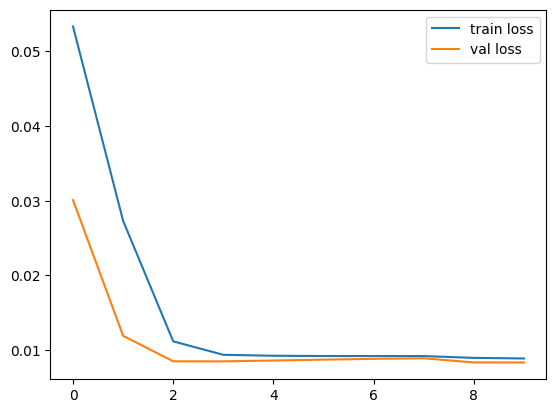

In [ ]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

# GRU - train

In [ ]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.MSELoss()
model = GRU(
    input_size=input_size,
    hidden_size=hidden_size,
    num_stacked_layers=num_stacked_layers
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

epochs = epochs
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]

for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Encode input data using the autoencoder
        with torch.no_grad():
            latent, _ = lstm_autoencoder_model.lstm_encoder(x_batch)
            latent = lstm_autoencoder_model.fc_encoder(latent)

        optimizer.zero_grad()
        outputs = model(latent)
        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Encode input data using the autoencoder
            latent, _ = lstm_autoencoder_model.lstm_encoder(x_batch)
            latent = lstm_autoencoder_model.fc_encoder(latent)

            outputs = model(latent)
            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'gru.pt')
        print(f'model epoch {epoch} saved as gru.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= early_stopping_limit:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

epoch 0
model epoch 0 saved as gru.pt
Epoch 1/10, train loss: 0.1089, val loss: 0.0630, time_taken: 4.3
epoch 1
model epoch 1 saved as gru.pt
Epoch 2/10, train loss: 0.0786, val loss: 0.0533, time_taken: 4.3
epoch 2
model epoch 2 saved as gru.pt
Epoch 3/10, train loss: 0.0577, val loss: 0.0310, time_taken: 3.9
epoch 3
model epoch 3 saved as gru.pt
Epoch 4/10, train loss: 0.0284, val loss: 0.0153, time_taken: 8.3
epoch 4
model epoch 4 saved as gru.pt
Epoch 5/10, train loss: 0.0169, val loss: 0.0132, time_taken: 7.9
epoch 5
model epoch 5 saved as gru.pt
Epoch 6/10, train loss: 0.0147, val loss: 0.0122, time_taken: 7.1
epoch 6
model epoch 6 saved as gru.pt
Epoch 7/10, train loss: 0.0133, val loss: 0.0112, time_taken: 5.7
epoch 7
model epoch 7 saved as gru.pt
Epoch 8/10, train loss: 0.0121, val loss: 0.0105, time_taken: 8.3
epoch 8
model epoch 8 saved as gru.pt
Epoch 9/10, train loss: 0.0112, val loss: 0.0098, time_taken: 5.5
epoch 9
model epoch 9 saved as gru.pt
Epoch 10/10, train loss: 0

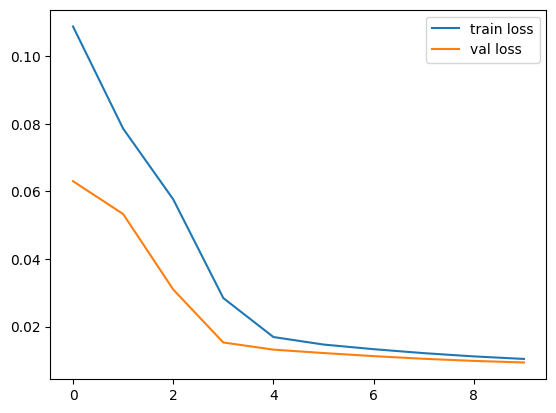

In [ ]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

# finetuning - evaluate

model loaded
model loaded
0.009703 0.07853


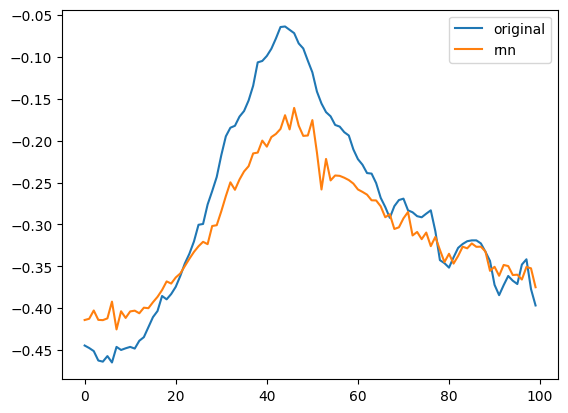

In [ ]:
# load best pretraining model
best_model_path = 'rnn.pt'
rnn_model = RNN(
    input_size=2,
    hidden_size=1,
    num_stacked_layers=1
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()
print('model loaded')

lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = 14, #features
    hidden_size = 4,
    num_stacked_layers = 1
).to(device)
lstm_autoencoder_model.load_state_dict(torch.load('lstm_autoencoder_model.pt',map_location=device))
lstm_autoencoder_model.eval()
print('model loaded')

# Encode input data using the autoencoder
latent, _ = lstm_autoencoder_model.lstm_encoder(X_test.to(device))
latent = lstm_autoencoder_model.fc_encoder(latent)

predictions = rnn_model(latent)
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.plot(y[-100:],label='original')
plt.plot(pred[-100:],label='rnn')
plt.legend()
plt.show()

model loaded
model loaded
0.009764 0.077963


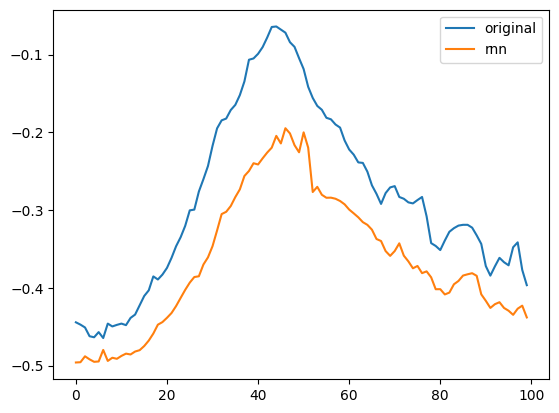

In [ ]:
# load best pretraining model
best_model_path = 'lstm.pt'
lstm_model = LSTM(
    input_size=2,
    hidden_size=1,
    num_stacked_layers=1
).to(device)
lstm_model.load_state_dict(torch.load(best_model_path,map_location=device))
lstm_model.eval()
print('model loaded')

lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = 14, #features
    hidden_size = 4,
    num_stacked_layers = 1
).to(device)
lstm_autoencoder_model.load_state_dict(torch.load('lstm_autoencoder_model.pt',map_location=device))
lstm_autoencoder_model.eval()
print('model loaded')

# Encode input data using the autoencoder
latent, _ = lstm_autoencoder_model.lstm_encoder(X_test.to(device))
latent = lstm_autoencoder_model.fc_encoder(latent)

predictions = lstm_model(latent)
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.plot(y[-100:],label='original')
plt.plot(pred[-100:],label='rnn')
plt.legend()
plt.show()

model loaded
model loaded
0.010535 0.081512


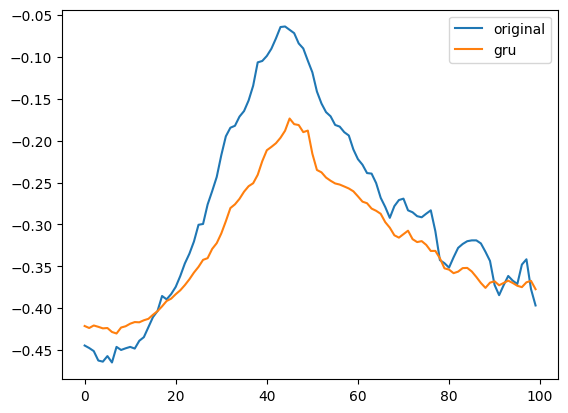

In [ ]:
# load best pretraining model
best_model_path = 'gru.pt'
gru_model = GRU(
    input_size=2,
    hidden_size=1,
    num_stacked_layers=1
).to(device)
gru_model.load_state_dict(torch.load(best_model_path,map_location=device))
gru_model.eval()
print('model loaded')

lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = 14, #features
    hidden_size = 4,
    num_stacked_layers = 1
).to(device)
lstm_autoencoder_model.load_state_dict(torch.load('lstm_autoencoder_model.pt',map_location=device))
lstm_autoencoder_model.eval()
print('model loaded')

# Encode input data using the autoencoder
latent, _ = lstm_autoencoder_model.lstm_encoder(X_test.to(device))
latent = lstm_autoencoder_model.fc_encoder(latent)

predictions = gru_model(latent)
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.plot(y[-100:],label='original')
plt.plot(pred[-100:],label='gru')
plt.legend()
plt.show()

0.009703 0.07853
0.009764 0.077963
0.010535 0.081512


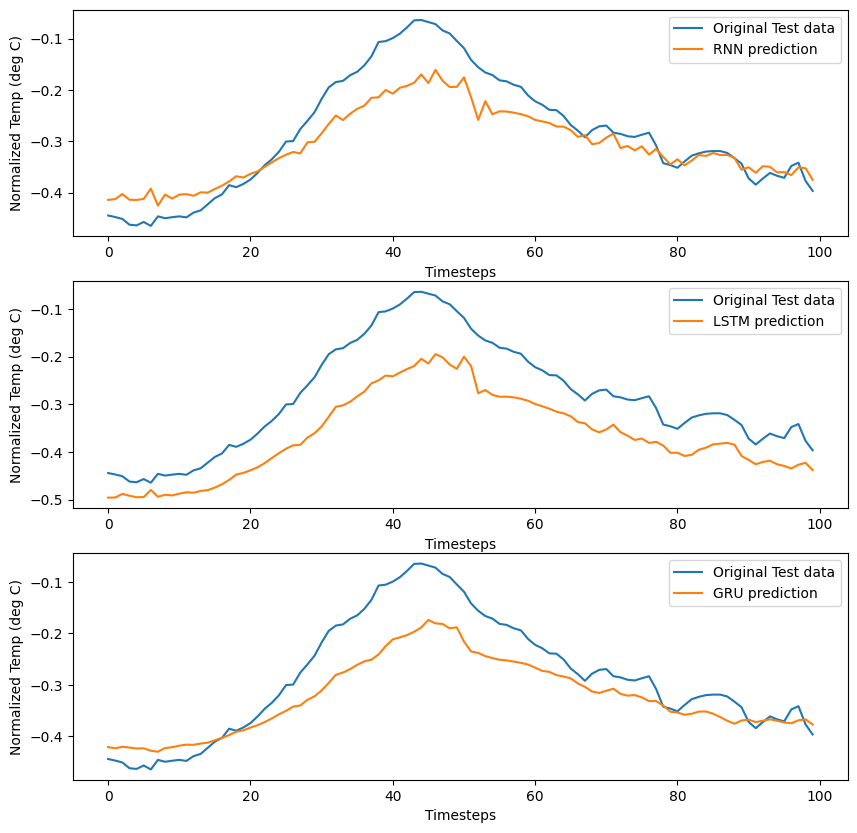

In [18]:
fig,ax=plt.subplots(3,1,figsize=(10,10))


# load best pretraining model
best_model_path = 'expt3/rnn.pt'
rnn_model = RNN(
    input_size=2,
    hidden_size=1,
    num_stacked_layers=1
).to(device)
rnn_model.load_state_dict(torch.load(best_model_path,map_location=device))
rnn_model.eval()
# print('model loaded')

lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = 14, #features
    hidden_size = 4,
    num_stacked_layers = 1
).to(device)
lstm_autoencoder_model.load_state_dict(torch.load('expt3/lstm_autoencoder_model.pt',map_location=device))
lstm_autoencoder_model.eval()
# print('model loaded')

# Encode input data using the autoencoder
latent, _ = lstm_autoencoder_model.lstm_encoder(X_test.to(device))
latent = lstm_autoencoder_model.fc_encoder(latent)

predictions = rnn_model(latent)
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.subplot(3,1,1)
plt.plot(y[-100:],label='Original Test data')
plt.plot(pred[-100:],label='RNN prediction')
plt.xlabel('Timesteps')
plt.ylabel('Normalized Temp (deg C)')
plt.legend()




# load best pretraining model
best_model_path = 'expt3/lstm.pt'
lstm_model = LSTM(
    input_size=2,
    hidden_size=1,
    num_stacked_layers=1
).to(device)
lstm_model.load_state_dict(torch.load(best_model_path,map_location=device))
lstm_model.eval()
# print('model loaded')

lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = 14, #features
    hidden_size = 4,
    num_stacked_layers = 1
).to(device)
lstm_autoencoder_model.load_state_dict(torch.load('expt3/lstm_autoencoder_model.pt',map_location=device))
lstm_autoencoder_model.eval()
# print('model loaded')

# Encode input data using the autoencoder
latent, _ = lstm_autoencoder_model.lstm_encoder(X_test.to(device))
latent = lstm_autoencoder_model.fc_encoder(latent)

predictions = lstm_model(latent)
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.subplot(3,1,2)
plt.plot(y[-100:],label='Original Test data')
plt.plot(pred[-100:],label='LSTM prediction')
plt.xlabel('Timesteps')
plt.ylabel('Normalized Temp (deg C)')
plt.legend()




# load best pretraining model
best_model_path = 'expt3/gru.pt'
gru_model = GRU(
    input_size=2,
    hidden_size=1,
    num_stacked_layers=1
).to(device)
gru_model.load_state_dict(torch.load(best_model_path,map_location=device))
gru_model.eval()
# print('model loaded')

lstm_autoencoder_model = LSTM_Autoencoder(
    input_size = 14, #features
    hidden_size = 4,
    num_stacked_layers = 1
).to(device)
lstm_autoencoder_model.load_state_dict(torch.load('expt3/lstm_autoencoder_model.pt',map_location=device))
lstm_autoencoder_model.eval()
# print('model loaded')

# Encode input data using the autoencoder
latent, _ = lstm_autoencoder_model.lstm_encoder(X_test.to(device))
latent = lstm_autoencoder_model.fc_encoder(latent)

predictions = gru_model(latent)
mse_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
mae_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
mse_loss = round(mse_loss.item(),6)
mae_loss = round(mae_loss.item(),6)
print(mse_loss,mae_loss)

# plot forecasting prediction
y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.subplot(3,1,3)
plt.plot(y[-100:],label='Original Test data')
plt.plot(pred[-100:],label='GRU prediction')
plt.xlabel('Timesteps')
plt.ylabel('Normalized Temp (deg C)')
plt.legend()

plt.savefig('expt3.png')

plt.show()